# Predicting Speed Dating Success Using Various Personality Traits

## Introduction



Speed dating is a popular dating practice that involves meeting multiple potential partners in a short period of time. This practice has gained popularity in recent years due to its effectiveness in helping people find compatible partners.

In this proposal, we will attempt to answer the following question: What individual characteristics are most important in predicting the success of speed dating? By analyzing data from a speed dating dataset, we will attempt to identify which factors are most strongly associated with successful matches.

The dataset we use contains information from speed dating events held in different cities in the United States. It includes information on participants' demographic characteristics, such as age, education level, and ethnicity, as well as their responses to survey questions related to their personalities, interests, and dating preferences, and whether or not each individual was matched with their potential partner.



## Methods and Results

#### 1. Importing Libraries

We begin by installing and importing the required libraries for this analysis.

In [1]:
# Install packages
# install.packages('tidyverse')
# install.packages('tidymodels')
# install.packages('repr')
# install.packages("cli")
# install.packages('gridExtra')
# install.packages('grid')
install.packages('kknn')

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [2]:
# Importing libraries
library(tidyverse)
library(tidymodels)
library(repr)
library(gridExtra)
library(grid)
library(kknn)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.8     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

Warning message:
“package ‘ggplot2’ was built under R version 4.1.3”
Warning message:
“package ‘tidyr’ was built under R version 4.1.2”
Warning message:
“package ‘readr’ was built under R version 4.1.2”
Warning message:
“package ‘dplyr’ was built under R version 4.1.3”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

Warni

#### 2. Reading the Data

Using the **read_csv()** function, we read the data from the source and store it in a variable. We perform a short analysis on the data, getting information about the number of columns, rows, as well as a preview of what each observation looks like. 

In [3]:
# Reading the data
speed_dating_data <- read_csv("http://www.stat.columbia.edu/~gelman/arm/examples/speed.dating/Speed%20Dating%20Data.csv")

# Number of Rows and Columns
num_rows <- nrow(speed_dating_data)
num_cols <- ncol(speed_dating_data)

speed_dating_summary <- tibble(Rows = num_rows, 
                  Columns = num_cols)

# Previewing the data
speed_dating_preview <- head(speed_dating_data)

Rows: 8378 Columns: 195
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr   (4): field, undergra, from, career
dbl (187): iid, id, gender, idg, condtn, wave, round, position, positin1, or...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [4]:
speed_dating_summary
speed_dating_preview

Rows,Columns
<int>,<int>
8378,195


iid,id,gender,idg,condtn,wave,round,position,positin1,order,⋯,attr3_3,sinc3_3,intel3_3,fun3_3,amb3_3,attr5_3,sinc5_3,intel5_3,fun5_3,amb5_3
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,0,1,1,1,10,7,NA,4,⋯,5,7,7,7,7,NA,NA,NA,NA,NA
1,1,0,1,1,1,10,7,NA,3,⋯,5,7,7,7,7,NA,NA,NA,NA,NA
1,1,0,1,1,1,10,7,NA,10,⋯,5,7,7,7,7,NA,NA,NA,NA,NA
1,1,0,1,1,1,10,7,NA,5,⋯,5,7,7,7,7,NA,NA,NA,NA,NA
1,1,0,1,1,1,10,7,NA,7,⋯,5,7,7,7,7,NA,NA,NA,NA,NA
1,1,0,1,1,1,10,7,NA,6,⋯,5,7,7,7,7,NA,NA,NA,NA,NA


#### 3. Summary Discussion

[link]: http://www.stat.columbia.edu/~gelman/arm/examples/speed.dating/Speed%20Dating%20Data%20Key.doc

From the speed dating dataset's [legend][link], we know there are many variables that are not useful in answering our research question, such as the individual's event ID, or the zipcode of where the individual was raised. There are many variables which do not use numerical values as well, such as the individual's career or field of study. Using 195 predictors would also be very computationally expensive, so we narrowed our possible predictors down to 6: attractiveness, sincerity, intelligence, funniness, and ambition. We chose these variables because they can be numerically rated, and are commonly discussed traits regarding relationships, and therefore would be variables to use to predict whether an individual would match with their partner or not. In step 6, we will further narrow down our predictors, by figuring out which variables have the highest correlation with whether or not the individual matches. 

#### 4. Tidying the Data

Our next step was to tidy the data into a state where we could easily use it to create our predictive model. We began by selecting the desired columns, and filtering out improper observations that could create future difficulties (N/A values, values that went by a different scale, etc.).

In [5]:
# Selecting desired rows
speed_dating_select <- speed_dating_data |>
    filter(wave != 6:9) |> # These waves had a different rating system for traits
    mutate(match = as_factor(match)) |>
    select(match, attr_o, sinc_o, intel_o, fun_o, amb_o, shar_o)

# Filtering the data of improper observations
speed_dating_tidy <- speed_dating_select |>
    filter(attr_o %% 1 == 0,
          sinc_o %% 1 == 0,
          intel_o %% 1 == 0,
          fun_o %% 1 == 0,
          amb_o %% 1 == 0, 
          shar_o %% 1 == 0,
          fun_o <= 10)

# Renaming categorical values
levels(speed_dating_tidy$match)[2] <- "yes"
levels(speed_dating_tidy$match)[1] <- "no"

# Renaming columns
colnames(speed_dating_tidy) <- c("Match", "Attractiveness", "Sincerity", "Intelligence", "Funniness", "Ambition", "Shared_Interest")

# Preview of tidied dataset
head(speed_dating_tidy)

Warning message in wave != 6:9:
“longer object length is not a multiple of shorter object length”


Match,Attractiveness,Sincerity,Intelligence,Funniness,Ambition,Shared_Interest
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
no,6,8,8,8,8,6
no,7,8,10,7,7,5
yes,10,10,10,10,10,10
yes,7,8,9,8,9,8
yes,8,7,9,6,9,7
no,7,7,8,8,7,7


#### 5. Column Legend
- **Match**: Whether or not the individual matched with their partner
- **Gender**: Gender of the individual
- **Attractiveness - Funniness**: How the individual was rated by their partner in each trait

#### 6. Variable Importance

Before we create our model, we will perform another analysis of the data, this time seeing which traits have the highest correlation with matching with their partner. We will do this by grouping the data by whether the observation matched or not, finding the means of each groups traits, then finding the difference between the two groups' means. A larger difference will imply a stronger correlation between the trait and whether or not the individual matches, while a smaller difference implies a weaker correlation. 

In [6]:
# Taking means of each trait
speed_dating_means <- speed_dating_tidy |>
    group_by(Match) |>
    summarize(Mean_Attractiveness = mean(Attractiveness),
              Mean_Sincerity = mean(Sincerity),
              Mean_Intelligence = mean(Intelligence),
              Mean_Funniness = mean(Funniness),
              Mean_Ambition = mean(Ambition), 
              Mean_Shared_Interest = mean(Shared_Interest))
speed_dating_means

Match,Mean_Attractiveness,Mean_Sincerity,Mean_Intelligence,Mean_Funniness,Mean_Ambition,Mean_Shared_Interest
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
no,5.953032,7.029332,7.233399,6.148101,6.645852,5.193990
yes,7.321429,7.815331,7.959930,7.617596,7.342334,6.776132


Now that we have the means, we will take the difference between the observations that matched and the ones that did not, to see which has the largest correlation. 

In [7]:
# Means of observations that matched
speed_dating_yes <- speed_dating_means |>
    slice(1) |>
    select(-Match) 

# Means of observations that did not match
speed_dating_no <- speed_dating_means |>
    slice(2) |>
    select(-Match)

# Taking the difference of "yes" and "no" means
speed_dating_diffs <- abs(speed_dating_yes - speed_dating_no)

# Renaming columns
colnames(speed_dating_diffs) <- c("Attract_Diff", "Sincere_Diff", "Intel_Diff", "Funny_Diff", "Ambition_Diff", "Shared_Interest_Diff")

speed_dating_diffs

Attract_Diff,Sincere_Diff,Intel_Diff,Funny_Diff,Ambition_Diff,Shared_Interest_Diff
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1.368396,0.7859986,0.726531,1.469494,0.6964824,1.582143


#### 7. Variable Discussion

From the table above, we observe that **attractiveness**, **funniness** and **shared interest** have a significantly stronger correlation with getting a match than the other traits. Therefore, we will create a model which only uses those 3 variables as predictors, as it will create a more accurate model.

#### 8. Creating the Classification Model

We will be creating a K-Nearest Neighbours classification model to predict whether an observation will match or not. To begin, we will split the data into a training set and a testing set, with proportions of 75% and 25%, respectfully. 

In [8]:
# Setting a seed
set.seed(1000)

# Splitting the data
speed_dating_split <- initial_split(speed_dating_tidy, prop = 0.75, strata = Match)
speed_dating_train <- training(speed_dating_split)
speed_dating_test <- testing(speed_dating_split)

Our next step is to determine a value of K which will give us the most accurate model. To do this, we will perform a 5 fold cross validation on the data, and create a plot of several K values against their accuracies. 

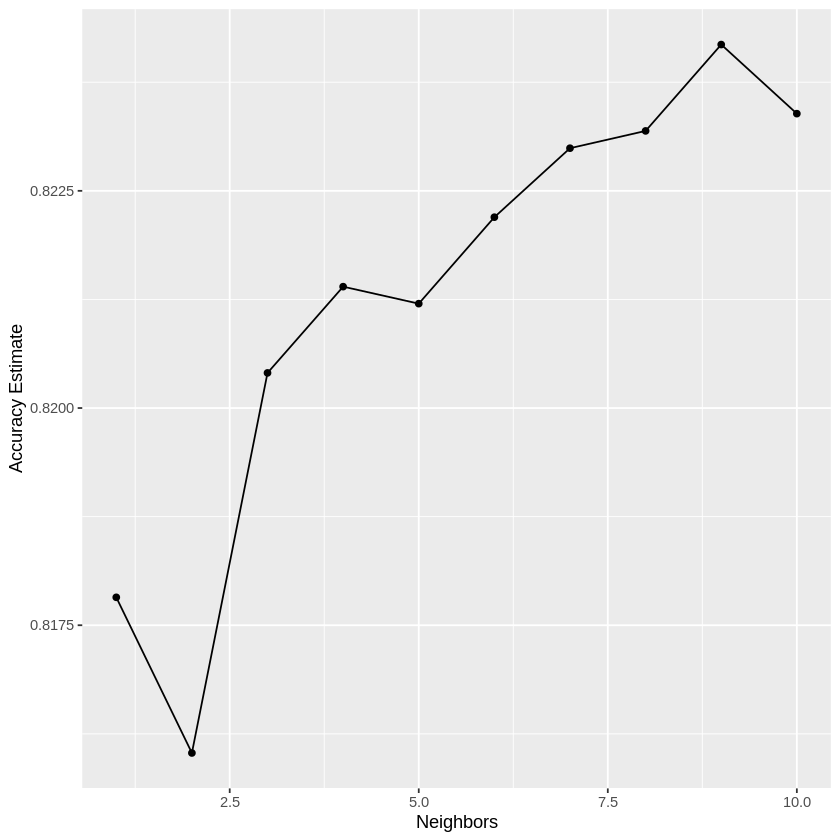

In [9]:
# Setting a seed
set.seed(1000)

# Creating a tuning model
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

# Creating the folds
speed_dating_vfold <- vfold_cv(data = speed_dating_train, v = 5, strata = Match)

# K values that we would like to test
k_value <- tibble(neighbors = seq(from = 1, to = 10, by = 1))

# Creating a scaled recipe
speed_dating_recipe <- recipe(Match ~ Attractiveness + Funniness + Shared_Interest, data = speed_dating_train)

# Performing the cross validation, and collecting the results
knn_results <- workflow() |>
    add_recipe(speed_dating_recipe) |>
    add_model(knn_tune) |>
    tune_grid(resamples = speed_dating_vfold, grid = k_value) |>
    collect_metrics() 

accuracies <- knn_results |>
    filter(.metric == "accuracy")

# Plotting the results
cross_val_plot <- accuracies |>
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate")
cross_val_plot

By observing the plot above and seeing which K value will result in the highest accuracy, we decide to create a K-NN Classification model which uses **9** neighbours. 

In [10]:
knn_optimal <- nearest_neighbor(weight_func = "rectangular", neighbors = 9) |>
    set_engine("kknn") |>
    set_mode("classification")

speed_dating_fit <- workflow() |>
    add_recipe(speed_dating_recipe) |>
    add_model(knn_optimal) |>
    fit(data = speed_dating_train)

#### Testing the model

Now that we have created a model, we will test it on the testing set from before to analyze the accuracy of this model.

In [11]:
predictions <- predict(speed_dating_fit, speed_dating_test) |>
    bind_cols(speed_dating_test)

accuracies <- predictions |>
    metrics(truth = Match, estimate = .pred_class)

accuracy_matrix <- predictions |>
    conf_mat(truth = Match, estimate = .pred_class)

(1385 + 3) / (1385 + 284 + 5 + 3)

accuracy_matrix
accuracies

[1] 0.8276685

          Truth
Prediction   no  yes
       no  1385  284
       yes    5    3

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.82766846
kap,binary,0.01116046


#### Results

The results of our model show that it has around an 83% accuracy. However, from the accuracy matrix produced when comparing the predictions and truths, we notice that the model will almost always predict an observation to not match, and due to the majority of observations not matching, the accuracy remains relatively high. This is due to a class imbalance in the dataset, since most observations do not match, as seen in the table below.

In [12]:
yes_count <- nrow(filter(speed_dating_tidy, Match == "yes"))
no_count <- nrow(filter(speed_dating_tidy, Match == "no"))

tibble(Matched = yes_count, 
       "Did Not Match" = no_count)

Matched,Did Not Match
<int>,<int>
1148,5557


To resolve this issue, we will **undersample** the observations that did not match, so our model will equally weight both classes. 

#### TODO: Undersampling?

## Discussion

## Summarize what you found

This project allows us to see which variables that correspond to the individuals traits that have a strong relation to how a couple get matched in speed dating.

## Discuss whether this is what you expected to find?

Yes, there are some things that we expected to find. We were expecting variables that are prominent in first impression of a person during speed dating tend to have a stronger relation with how likely the couple get matched than variables that require a deeper understanding of someone.

## Discuss what impact could such findings have?

The project has a potential to help researchers that focus on human relationship to understand which human characters or traits that determine the success rate couple of getting matched in speed dating. This project could be a helpful tool to identify human nature in speed dating. Moreover, this project also gives contribution in the data science field especially K-NN Regression.

## Discuss what future questions could this lead to?




## References